In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Libraries**

In [13]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**File Paths**

In [3]:
BASE_DIR = '/content/drive/MyDrive/MLL/Brain Tumor data/Brain Tumor data'
TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DIR  = os.path.join(BASE_DIR, 'Testing')

if not os.path.exists(BASE_DIR):
    raise FileNotFoundError("Base directory not found!")

print("Train classes:", os.listdir(TRAIN_DIR))
print("Test  classes:", os.listdir(TEST_DIR))


Train classes: ['meningioma', 'glioma', 'pituitary', 'notumor']
Test  classes: ['pituitary', 'notumor', 'glioma', 'meningioma']


**No. of Images Per Class**

*Training data distribution*

Number of images per category in Training directory:
meningioma: 1339
glioma: 1321
pituitary: 1457
notumor: 1595


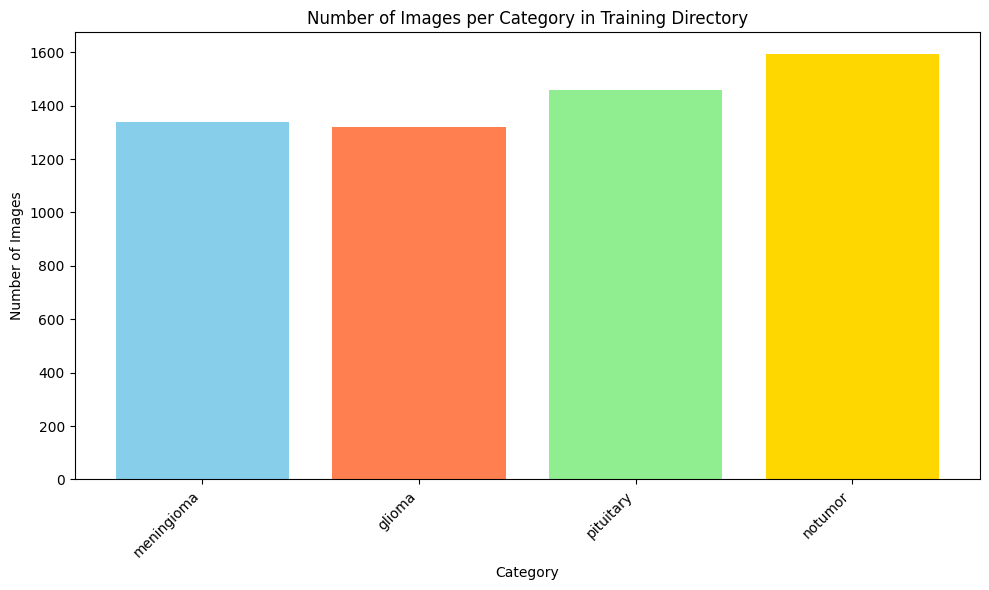

In [4]:
categories = os.listdir(TRAIN_DIR)
image_counts = {}

for category in categories:
    category_path = os.path.join(TRAIN_DIR, category)
    count = 0
    if os.path.isdir(category_path):
        for item in os.listdir(category_path):
            item_path = os.path.join(category_path, item)
            if os.path.isfile(item_path):
                ext = os.path.splitext(item_path)[1].lower()
                if ext in ('.jpg', '.jpeg', '.png', '.gif'):
                    count += 1
    image_counts[category] = count

print("Number of images per category in Training directory:")
for category, count in image_counts.items():
    print(f"{category}: {count}")

plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'coral', 'lightgreen', 'gold'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Training Directory')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Testing data distribution*

Number of images per category in Testing directory:
pituitary: 300
notumor: 405
glioma: 300
meningioma: 306


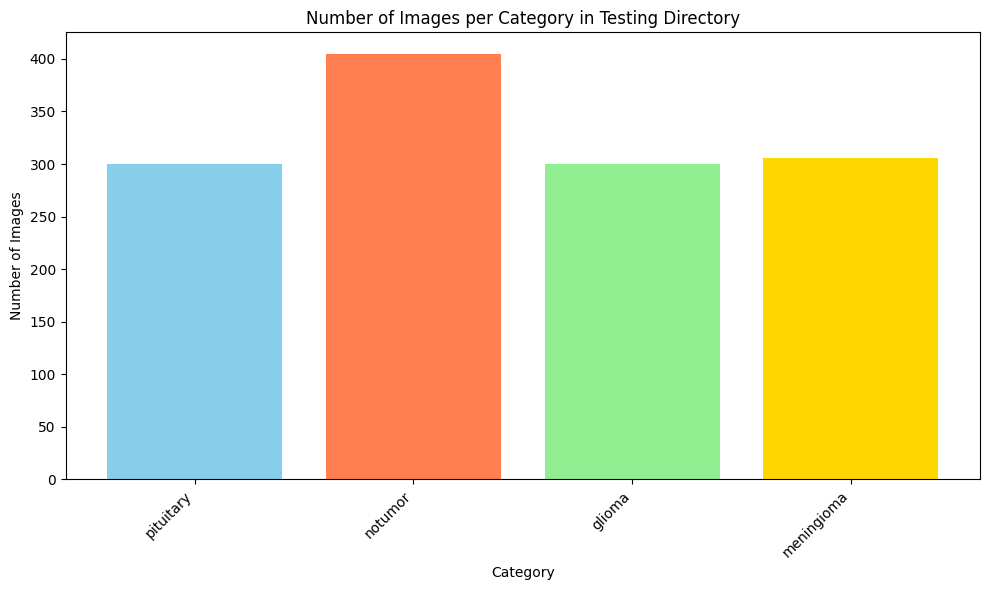

In [5]:
categories = os.listdir(TEST_DIR)
image_counts = {}

for category in categories:
    category_path = os.path.join(TEST_DIR, category)
    count = 0
    if os.path.isdir(category_path):
        for item in os.listdir(category_path):
            item_path = os.path.join(category_path, item)
            if os.path.isfile(item_path):
                ext = os.path.splitext(item_path)[1].lower()
                if ext in ('.jpg', '.jpeg', '.png', '.gif'):
                    count += 1
    image_counts[category] = count

print("Number of images per category in Testing directory:")
for category, count in image_counts.items():
    print(f"{category}: {count}")

plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'coral', 'lightgreen', 'gold'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Testing Directory')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Sample Images **

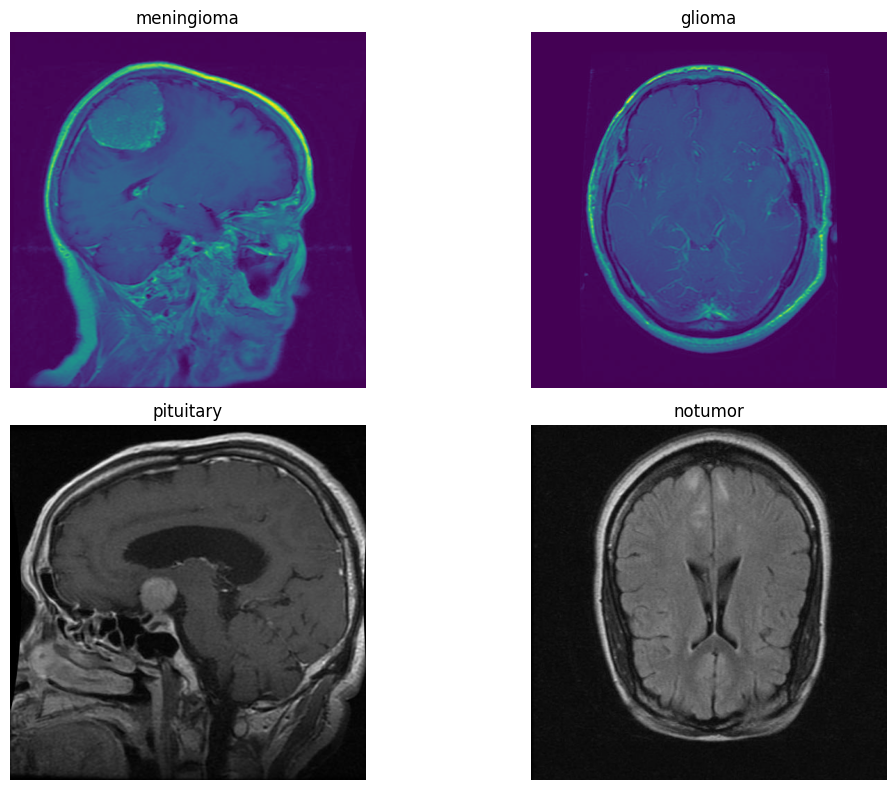

In [6]:
plt.figure(figsize=(12,8))
categories = os.listdir(TRAIN_DIR)

for i, cls in enumerate(categories):
    cls_path = os.path.join(TRAIN_DIR, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)

    img = mpimg.imread(img_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


Global Parameters

In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [8]:
preprocess_func = resnet_preprocess

Data Augmentation

In [9]:

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_func,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.20,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_func,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_func
)


In [10]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Augmented sample images

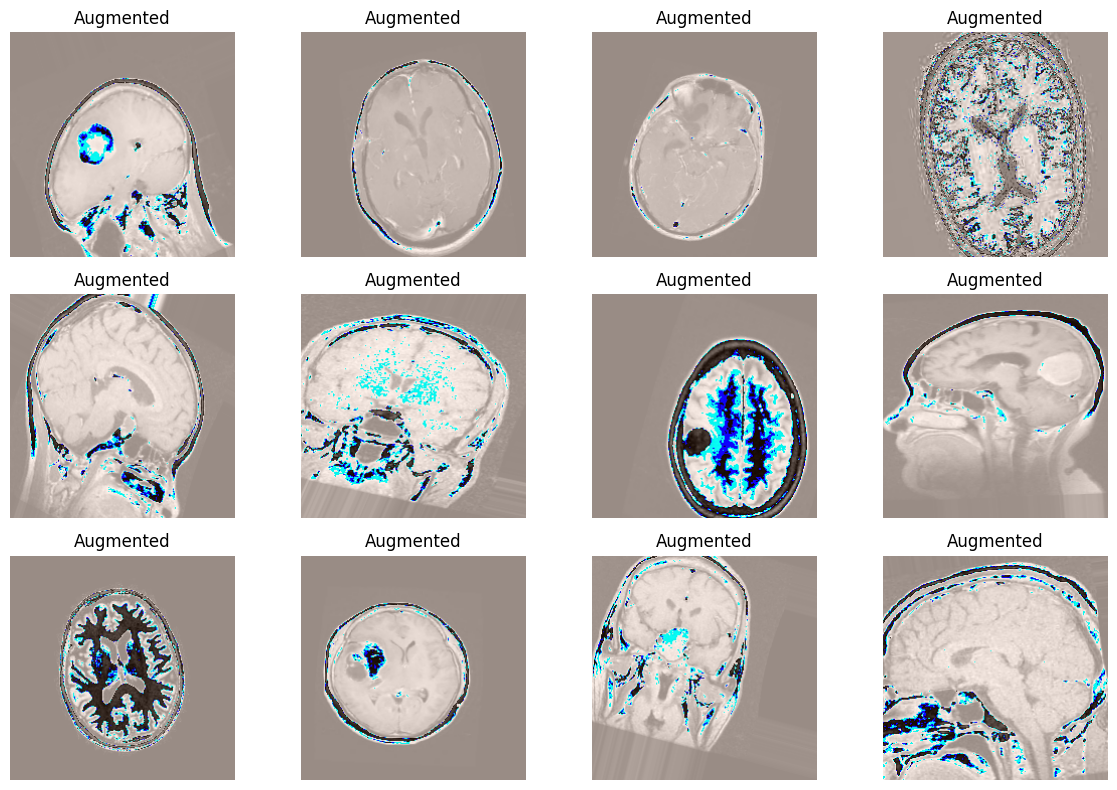

In [11]:

augmented_images, augmented_labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(augmented_images[i].astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
# ===========================
# VERIFY SETUP
# ===========================
print("\n" + "="*50)
print("DATA GENERATORS SUMMARY")
print("="*50)
print(f"Training samples:   {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples:       {test_generator.samples}")
print(f"Number of classes:  {train_generator.num_classes}")
print(f"Class indices:      {train_generator.class_indices}")
print("="*50)

# Extract class names
class_names = list(train_generator.class_indices.keys())
print(f"Class Names: {class_names}")
NUM_CLASSES = len(class_names)


DATA GENERATORS SUMMARY
Training samples:   4571
Validation samples: 1141
Test samples:       1311
Number of classes:  4
Class indices:      {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


ResNet50

In [ ]:


# Number of classes
NUM_CLASSES = train_generator.num_classes

# Build ResNet50 base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Freeze base model for initial training
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
monitor_metric = 'val_accuracy'

checkpoint = ModelCheckpoint(
    '/content/best_resnet50_brain_tumor.h5',
    monitor=monitor_metric,
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor=monitor_metric,
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# =========================
#        TRAIN MODEL
# =========================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

# =========================
#    PLOT ACCURACY & LOSS
# =========================
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# =========================
#  FINAL TRAIN / VAL STATS
# =========================
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy:   {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss:       {final_train_loss:.4f}")
print(f"Final Validation Loss:     {final_val_loss:.4f}")



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.3082 - loss: 1.7739 
Epoch 1: val_accuracy improved from -inf to 0.45837, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 2888s 20s/step - accuracy: 0.3088 - loss: 1.7721 - val_accuracy: 0.4584 - val_loss: 1.2148
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5720 - loss: 1.0374
Epoch 2: val_accuracy improved from 0.45837 to 0.60035, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 1138s 8s/step - accuracy: 0.5723 - loss: 1.0368 - val_accuracy: 0.6004 - val_loss: 1.0107
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6869 - loss: 0.8022
Epoch 3: val_accuracy improved from 0.60035 to 0.66258, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 1182s 8s/step - accuracy: 0.6870 - loss: 0.8019 - val_accuracy: 0.6626 - val_loss: 0.9110
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7454 - loss: 0.6614
Epoch 4: val_accuracy improved from 0.66258 to 0.68624, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 1132s 8s/step - accuracy: 0.7455 - loss: 0.6613 - val_accuracy: 0.6862 - val_loss: 0.8592
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7664 - loss: 0.6190
Epoch 5: val_accuracy improved from 0.68624 to 0.71604, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 1140s 8s/step - accuracy: 0.7665 - loss: 0.6189 - val_accuracy: 0.7160 - val_loss: 0.7989
Epoch 6/20
 20/143 ━━━━━━━━━━━━━━━━━━━━ 13:51 7s/step - accuracy: 0.8225 - loss: 0.4753

In [ ]:
# =========================
#      TEST EVALUATION
# =========================
# Ensure generator starts from the first sample
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# =========================
#  PREDICTIONS & METRICS
# =========================
# Reset again before predicting
test_generator.reset()
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

class_indices = test_generator.class_indices
target_names = list(class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base ResNet50 model (pretrained)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze layers (transfer learning)
base_model.trainable = False

# Add your classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3614 - loss: 1.6229
Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 1794s 12s/step - accuracy: 0.3619 - loss: 1.6214 - val_accuracy: 0.4917 - val_loss: 1.2093
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.5695 - loss: 1.0412
Epoch 2: val_accuracy improved from 0.49167 to 0.65557, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 703ms/step - accuracy: 0.5697 - loss: 1.0406 - val_accuracy: 0.6556 - val_loss: 1.0248
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.6781 - loss: 0.8207
Epoch 3: val_accuracy improved from 0.65557 to 0.67397, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 692ms/step - accuracy: 0.6782 - loss: 0.8205 - val_accuracy: 0.6740 - val_loss: 0.9219
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7407 - loss: 0.6787
Epoch 4: val_accuracy improved from 0.67397 to 0.70114, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 704ms/step - accuracy: 0.7407 - loss: 0.6787 - val_accuracy: 0.7011 - val_loss: 0.8571
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7559 - loss: 0.6305
Epoch 5: val_accuracy improved from 0.70114 to 0.70727, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 693ms/step - accuracy: 0.7559 - loss: 0.6305 - val_accuracy: 0.7073 - val_loss: 0.7965
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.7807 - loss: 0.5710
Epoch 6: val_accuracy improved from 0.70727 to 0.72393, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 700ms/step - accuracy: 0.7808 - loss: 0.5710 - val_accuracy: 0.7239 - val_loss: 0.7534
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8019 - loss: 0.5254
Epoch 7: val_accuracy improved from 0.72393 to 0.73094, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 690ms/step - accuracy: 0.8019 - loss: 0.5254 - val_accuracy: 0.7309 - val_loss: 0.7267
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8091 - loss: 0.4935
Epoch 8: val_accuracy improved from 0.73094 to 0.73620, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 694ms/step - accuracy: 0.8091 - loss: 0.4935 - val_accuracy: 0.7362 - val_loss: 0.7112
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8098 - loss: 0.4960
Epoch 9: val_accuracy improved from 0.73620 to 0.73970, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 98s 685ms/step - accuracy: 0.8098 - loss: 0.4960 - val_accuracy: 0.7397 - val_loss: 0.7080
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8304 - loss: 0.4491
Epoch 10: val_accuracy improved from 0.73970 to 0.74233, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 98s 688ms/step - accuracy: 0.8304 - loss: 0.4492 - val_accuracy: 0.7423 - val_loss: 0.6736
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.8239 - loss: 0.4579
Epoch 11: val_accuracy improved from 0.74233 to 0.75285, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 114s 796ms/step - accuracy: 0.8239 - loss: 0.4579 - val_accuracy: 0.7528 - val_loss: 0.6647
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8432 - loss: 0.4213
Epoch 12: val_accuracy improved from 0.75285 to 0.76599, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 692ms/step - accuracy: 0.8432 - loss: 0.4212 - val_accuracy: 0.7660 - val_loss: 0.6202
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.8391 - loss: 0.4267
Epoch 13: val_accuracy improved from 0.76599 to 0.76775, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 691ms/step - accuracy: 0.8391 - loss: 0.4266 - val_accuracy: 0.7677 - val_loss: 0.5940
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8542 - loss: 0.3938
Epoch 14: val_accuracy improved from 0.76775 to 0.78177, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 98s 689ms/step - accuracy: 0.8541 - loss: 0.3938 - val_accuracy: 0.7818 - val_loss: 0.5937
Epoch 15/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8503 - loss: 0.4087
Epoch 15: val_accuracy did not improve from 0.78177
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 688ms/step - accuracy: 0.8503 - loss: 0.4088 - val_accuracy: 0.7809 - val_loss: 0.5798
Epoch 16/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8605 - loss: 0.3718
Epoch 16: val_accuracy did not improve from 0.78177
143/143 ━━━━━━━━━━━━━━━━━━━━ 98s 684ms/step - accuracy: 0.8605 - loss: 0.3719 - val_accuracy: 0.7599 - val_loss: 0.6011
Epoch 17/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8567 - loss: 0.3737
Epoch 17: val_accuracy improved from 0.78177 to 0.79053, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 696ms/step - accuracy: 0.8567 - loss: 0.3738 - val_accuracy: 0.7905 - val_loss: 0.5931
Epoch 18/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8571 - loss: 0.3775
Epoch 18: val_accuracy did not improve from 0.79053
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 691ms/step - accuracy: 0.8571 - loss: 0.3776 - val_accuracy: 0.7686 - val_loss: 0.5624
Epoch 19/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8626 - loss: 0.3613
Epoch 19: val_accuracy did not improve from 0.79053
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 698ms/step - accuracy: 0.8625 - loss: 0.3613 - val_accuracy: 0.7853 - val_loss: 0.5436
Epoch 20/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.8660 - loss: 0.3528
Epoch 20: val_accuracy did not improve from 0.79053
143/143 ━━━━━━━━━━━━━━━━━━━━ 127s 889ms/step - accuracy: 0.8660 - loss: 0.3529 - val_accuracy: 0.7879 - val_loss: 0.5664
Restoring model weights from the end of the best epoch: 19.


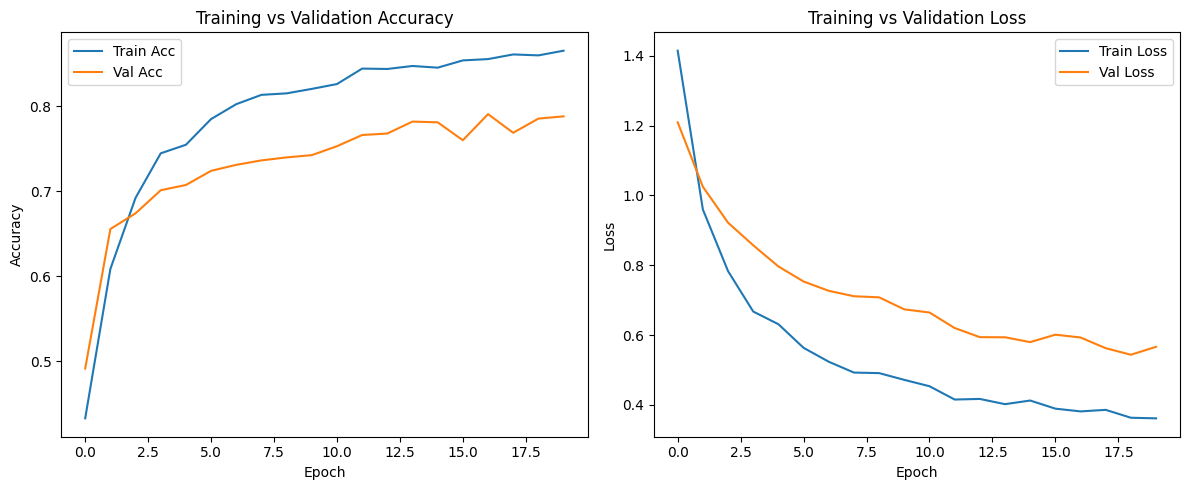

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "/content/best_resnet50_brain_tumor.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.7814 - loss: 0.5654

Test Loss: 0.4337
Test Accuracy: 0.8406
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.89      0.80      0.84       300
  meningioma       0.74      0.60      0.66       306
     notumor       0.88      0.94      0.91       405
   pituitary       0.82      0.99      0.90       300

    accuracy                           0.84      1311
   macro avg       0.83      0.83      0.83      1311
weighted avg       0.84      0.84      0.83      1311



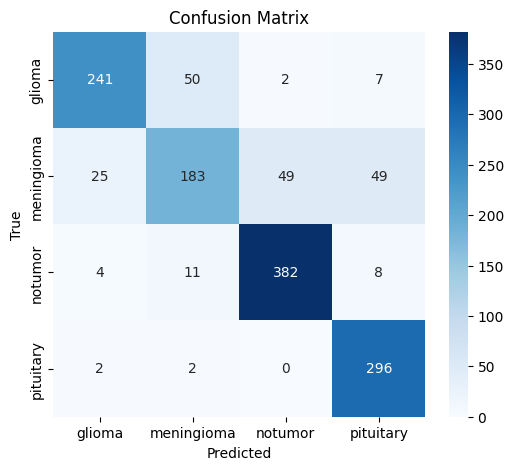

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# Predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Labels
target_names = list(test_generator.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")


Final Training Accuracy: 0.8650
Final Validation Accuracy: 0.7879
Final Training Loss: 0.3615
Final Validation Loss: 0.5664
